In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import sys

from scipy.stats import gamma, beta
import talib
from tqdm.notebook import tqdm
from functools import partial
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
sys.path.append("../src")
from networks_10092022 import DynamicGaussianNetworkJoint
from priors import diffusion_prior, random_walk_prior
from micro_models import dynamic_batch_diffusion, diffusion_trial, fast_dm_simulate
from macro_models import random_walk_shared_var, random_walk
from context import generate_design_matrix
from transformations import scale_z, unscale_z

In [ ]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

In [ ]:
# # gpu setting and checking
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

In [ ]:
N_OBS      = 3200
BATCH_SIZE = 8
N_SAMPLES  = 2000
N_PARAMS   = 6
N_SIM      = 100

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [ ]:
MACRO_MEAN  = beta(a=1, b=25).mean()
MACRO_STD   = beta(a=1, b=25).std()
MICRO_MEANS = [1.75, 1.75, 1.75, 1.75, 1.7, 1] # calculated based on 10000 simulated theta_1:3200
MICRO_STDS   = [1.5, 1.5, 1.5, 1.5, 1.25, 1] # calculated based on 10000 simulated theta_1:3200

In [ ]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [ ]:
def generator_fun(batch_size, T):
    theta = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = random_walk_prior(batch_size, N_PARAMS)
    theta_t = random_walk(theta, eta, T)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context).astype(np.float32)
    x = tf.concat((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    
    theta_t_z = theta_t.copy()
    for i in range(theta_t.shape[0]):
        theta_t_z[i] =  scale_z(theta_t[i], MICRO_MEANS,  MICRO_STDS)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x

In [ ]:
%%time
eta_z, theta_t_z, x = generator_fun(BATCH_SIZE, N_OBS)
theta_t_z.shape

In [ ]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            macro_params, micro_params, data = generator() 

            # Forward pass
            posterior = network(data)

            # loss computation
            T = int(micro_params.shape[1])
            loss = nll(tf.concat([tf.stack([macro_params] * T, axis=1), micro_params], axis=-1), posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [ ]:
T = 3200
batch_size = 8
simulator = partial(generator_fun, T=T, batch_size=batch_size)
epochs = 100
steps_per_epoch = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
network_settings = {
    'embedding_lstm_units' : 512, 
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [ ]:
# losses = []
# for ep in range(1, epochs+1):
#     with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(losses_ep)

In [ ]:
# network.save_weights('../trained_networks/full_dynamic_dm_3200_joint')

## Evaluation

In [ ]:
network.load_weights('../trained_networks/full_dynamic_dm_3200_joint')

In [ ]:
# read data
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

# prepare data for fitting
ids = np.unique(data.id)
N_SUBS = len(ids)

# negative rts for error responses
data.rt.loc[data.acc == 0] = -data.rt.loc[data.acc == 0]

# iterate over subjects
x_nn = np.zeros((len(ids), N_OBS, 5))

for id in ids:
    person_data = data[data.id == id]
    rt = np.array([person_data.rt])[:, :, np.newaxis]
    stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn[id-1] = tf.concat((rt, context), axis=-1)

x_nn.shape

In [ ]:
# amortized inference
post_eta_z = np.zeros((N_SAMPLES, N_SUBS, N_OBS, N_PARAMS))
post_theta_t_z = np.zeros((N_SAMPLES, N_SUBS, N_OBS, N_PARAMS))
for i in range(len(ids)):
    post_eta_z[:, i:i+1, :, :], post_theta_t_z[:, i:i+1, :, :] = network.sample_n(x_nn[i:i+1], N_SAMPLES)
    print("Sub nr. {} is fitted".format(i+1))

In [ ]:
post_eta = unscale_z(post_eta_z, MACRO_MEAN, MACRO_STD)
post_theta_t = unscale_z(post_theta_t_z, MICRO_MEANS, MICRO_STDS)

In [ ]:
# np.save("../saved_arrays/post_eta_all_sub_joint.npy", post_eta)
# np.save("../saved_arrays/post_theta_t_all_sub_joint.npy", post_theta_t)

In [ ]:
# post_eta = np.load("../saved_arrays/post_eta_all_sub_joint.npy")
# post_theta_t = np.load("../saved_arrays/post_theta_t_all_sub_joint.npy")

In [ ]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('../data/parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params = fast_dm_params.to_numpy()[:, 1:]
fast_dm_params.shape

In [ ]:
# predict data with fast_dm for all subjects
pred_rt_fast_dm = np.zeros((N_SUBS, N_OBS))
for i in range(N_SUBS):
    context = data.stim_type.loc[data.id == i+1].to_numpy() - 1
    pred_rt_fast_dm[i] = fast_dm_simulate(fast_dm_params[i], context)
    
pred_rt_fast_dm.shape

In [ ]:
# np.save("../saved_arrays/fast_dm_params.npy", fast_dm_params)
# np.save("../saved_arrays/pred_rt_fast_dm.npy", pred_rt_fast_dm)

In [ ]:
fast_dm_params = np.load("../saved_arrays/fast_dm_params.npy")
pred_rt_fast_dm = np.load("../saved_arrays/pred_rt_fast_dm.npy")

## Evaluation: RT over time

In [ ]:
def pr_check(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/n_sim, dtype=np.int32)
    theta = post_theta_t[idx]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta[sim, t, context[t]], theta[sim, t, 4], theta[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [ ]:
# predict data with neural for all subjects
pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))
sma_pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))

pred_rt_quantiles = np.zeros((N_SUBS, 2, N_OBS))
pred_rt_medians = np.zeros((N_SUBS, N_OBS))

emp_rt =  np.zeros((N_SUBS, N_OBS))
sma_emp_rt =  np.zeros((N_SUBS, N_OBS))

for sub in range(N_SUBS):
    # predict RTs
    person_data = data[data.id == sub+1]
    pred_rt_neural[sub], sma_pred_rt_neural[sub], emp_rt[sub], sma_emp_rt[sub] = pr_check(person_data, post_theta_t[:, sub, :, :], N_SIM)
    # compute RT quantiles
    pred_rt_quantiles[sub] = np.quantile(sma_pred_rt_neural[sub], [0.025, 0.975], axis=0)
    pred_rt_medians[sub] = np.median(sma_pred_rt_neural[sub], axis=0)
    print("Sub nr. {} is predicted".format(sub+1))

In [ ]:
np.save("../saved_arrays/pred_rt_neural_joint", pred_rt_neural)
np.save("../saved_arrays/sma_pred_rt_neural_joint", sma_pred_rt_neural)
np.save("../saved_arrays/pred_rt_quantiles_joint", pred_rt_quantiles)
np.save("../saved_arrays/pred_rt_medians_joint", pred_rt_medians)
np.save("../saved_arrays/emp_rt_joint", emp_rt)
np.save("../saved_arrays/sma_emp_rt_joint", sma_emp_rt)

In [ ]:
pred_rt_neural = np.load("../saved_arrays/pred_rt_neural_joint.npy")
sma_pred_rt_neural = np.load("../saved_arrays/sma_pred_rt_neural_joint.npy")
pred_rt_quantiles = np.load("../saved_arrays/pred_rt_quantiles_joint.npy")
pred_rt_medians = np.load("../saved_arrays/pred_rt_medians_joint.npy")
emp_rt = np.load("../saved_arrays/emp_rt_joint.npy")
sma_emp_rt = np.load("../saved_arrays/sma_emp_rt_joint.npy")

In [ ]:
horizon=800
emp_data_horizon = x_nn[:, :N_OBS-horizon, :]

# inference on restircted data
post_eta_z_horizon = np.zeros((N_SAMPLES, N_SUBS, N_OBS-horizon, N_PARAMS))
post_theta_t_z_horizon = np.zeros((N_SAMPLES, N_SUBS, N_OBS-horizon, N_PARAMS))
for i in range(len(ids)):
    post_eta_z_horizon[:, i:i+1, :, :], post_theta_t_z_horizon[:, i:i+1, :, :] = network.sample_n(emp_data_horizon[i:i+1], N_SAMPLES)
    print("Sub nr. {} is fitted".format(i+1))

In [ ]:
post_eta_last = unscale_z(post_eta_z_horizon[:, :, -1, :], MACRO_MEAN, MACRO_STD)
post_theta_last = unscale_z(post_theta_t_z_horizon[:, :, -1, :], MICRO_MEANS,  MICRO_STDS)

In [ ]:
# calcualte mean posteriors
post_eta_last_means = post_eta_last.mean(axis=0)
post_theta_last_means = post_theta_last.mean(axis=0)

In [ ]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))

context = x_nn[:, :, 1:].argmax(axis=2)[:, T-horizon:]

for sub in range(N_SUBS):
    for i in range(N_SIM):
        pred_theta_t = random_walk(post_theta_last_means[sub:sub+1], post_eta_last_means[sub:sub+1], horizon)
        pred_rt_horizon[i, sub:sub+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sub:sub+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sub, :, 0] = talib.SMA(pred_rt_horizon[i, sub, :, 0], timeperiod=5)

    print("Sub nr. {} is predicted".format(sub+1))

In [ ]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.025, 0.975], axis=0)

In [ ]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

In [ ]:
np.save('../saved_arrays/emp_rt.npy', emp_rt)
np.save('../saved_arrays/sma_emp_rt.npy', sma_emp_rt)
np.save('../saved_arrays/pred_rt_fast_dm.npy', pred_rt_fast_dm)
np.save('../saved_arrays/pred_rt_neural.npy', pred_rt_neural)
np.save('../saved_arrays/pred_rt_medians.npy', pred_rt_medians)
np.save('../saved_arrays/pred_rt_quantiles.npy', pred_rt_quantiles)
np.save('../saved_arrays/pred_rt_horizon_medians.npy', pred_rt_horizon_medians)
np.save('../saved_arrays/pred_rt_horizon_quantiles.npy', pred_rt_horizon_quantiles)

In [ ]:
emp_rt = np.load('../saved_arrays/emp_rt_joint.npy')
sma_emp_rt = np.load('../saved_arrays/sma_emp_rt_joint.npy')
pred_rt_fast_dm = np.load('../saved_arrays/pred_rt_fast_dm.npy')
pred_rt_neural = np.load('../saved_arrays/pred_rt_neural_joint.npy')
pred_rt_medians = np.load('../saved_arrays/pred_rt_medians_joint.npy')
pred_rt_quantiles = np.load('../saved_arrays/pred_rt_quantiles_joint.npy')
pred_rt_horizon_medians = np.load('../saved_arrays/pred_rt_horizon_medians.npy')
pred_rt_horizon_quantiles = np.load('../saved_arrays/pred_rt_horizon_quantiles.npy')

In [ ]:
# initialize figure
horizon = 800
for sub in range(N_SUBS):
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})
    axrr = ax.flat
    # plot empiric and predicted response times series
    time = np.arange(N_OBS) 

    axrr[0].plot(time, sma_emp_rt[sub], color="#062759", lw=1.4, alpha=0.7, label='SMA5: Empiric')
    axrr[0].plot(time[:N_OBS-horizon], pred_rt_medians[sub, :N_OBS-horizon], color='#852626', lw=1.4, label='SMA5: Retrodicted median', alpha=0.8)
    axrr[0].plot(time[N_OBS-horizon:], pred_rt_horizon_medians[sub], color="#b35032", lw=1.4, label='SMA5: Predicted multi-horizon median', alpha=0.6)
    axrr[0].fill_between(time[N_OBS-horizon:], pred_rt_horizon_quantiles[0, sub, :, 0], pred_rt_horizon_quantiles[1, sub, :, 0], color="#b35032", linewidth=0, alpha=0.4, label='Multi-horizon predictive uncertainty')
    axrr[0].fill_between(time[:N_OBS-horizon], pred_rt_quantiles[sub, 0, :N_OBS-horizon], pred_rt_quantiles[sub, 1, :N_OBS-horizon], color='#852626', linewidth=0, alpha=0.5, label='Retrodictive uncertainty')
    for idx in np.argwhere(person_data.session.diff().values == 1):
        if idx == 800:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
        else:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    for idx in np.argwhere(person_data.block.diff().values == 1):
        if idx == 100:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    sns.despine(ax=axrr[0])
    axrr[0].grid(alpha=0.3)
    axrr[0].set_ylabel('RT(s)', fontsize=18, rotation=0, labelpad=40)
    axrr[0].set_xlabel('\nTrial', fontsize=18)
    axrr[0].tick_params(axis='both', which='major', labelsize=16)

    f.legend(fontsize=16, loc='center', 
            bbox_to_anchor=(0.5, -0.05), ncol=3)

    axrr[0].grid(b=None)
    axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

    # plot empiric and predicted response time dist
    plt.setp(ax, ylim=(0, 1.5))
    sns.histplot(y=np.abs(emp_rt[sub]), fill="#062759", color="#062759", alpha=0.7, label="Empiric", ax=axrr[1], stat="density", bins=250, linewidth=0)
    sns.kdeplot(y=np.abs(pred_rt_fast_dm[sub]), fill= "#598f70", color="#598f70", alpha=0.3, label="Fast-dm", ax=axrr[1], linewidth=3.5)
    sns.kdeplot(y=pred_rt_neural[sub].flatten(), fill="#852626", color="#852626", alpha=0.3, label="Dynamic DDM", ax=axrr[1], linewidth=3.5)

    axrr[1].legend(fontsize=16)
    axrr[1].set_xlabel('', fontsize=18)
    axrr[1].tick_params(axis='both', which='major', labelsize=16)
    axrr[1].set_yticklabels('')
    axrr[1].set_xticklabels('')
    axrr[1].xaxis.set_ticks([])
    axrr[1].yaxis.set_ticks([])
    axrr[1].get_xaxis().set_visible(False)
    for line in axrr[1].get_lines():
        line.set_alpha(1)
    sns.despine(ax=axrr[1], bottom=True)

    axrr[0].annotate('Retrodiction',
                xy=(0.38, 1), xytext=(0, -15),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].annotate('Prediction',
                xy=(0.84, 1), xytext=(0, -15),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].tick_params(length=8)

    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    f.savefig("../plots/rt_time_series_sub_{}.png".format(sub+1), dpi=300, bbox_inches='tight')

## Evaluation: Parameter Dynamics

In [ ]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    std = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0).max()
    upper_y_ax = post_max + 1

    sigma_factors = [1]
    alphas = [0.6]

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Post. mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Post. std. deviation')
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        # ax.set_xlabel('Trial', fontsize=18)
        # ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)


        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)
        if i < 4:
            ax.set_ylim(0, upper_y_ax)
        else:
            ax.set_ylim(0)
        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[6], fast_dm_params[i] + fast_dm_params[6], color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')
        elif i == 4:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
        else:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[7]/2, fast_dm_params[i] + fast_dm_params[7]/2, color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()
    f.savefig("../plots/param_dynamic_sub_{}.png".format(sub+1), dpi=300, bbox_inches="tight")

In [ ]:
for sub in range(N_SUBS):
    plot_dynamic_posteriors(post_theta_t[:, sub, :, :], fast_dm_params[sub], PARAM_LABELS, PARAM_NAMES)

## Evaluation: Average Parameter Dynamic

In [ ]:
# Plot average parameter dynamc
color_pred='#852626'

# compute means and stds for neural and fast-dm parameters
neural_means = post_theta_t.mean(axis=0).mean(axis=0)
neural_stds = post_theta_t.mean(axis=0).std(axis=0)

fast_dm_means = fast_dm_params.mean(axis=0)
fast_dm_sd = fast_dm_params.std(axis=0)

post_max = np.array(neural_means).max(axis=0).max()
upper_y_ax = post_max + 1

sigma_factors = [1]
alphas = [0.6]

time = np.arange(N_OBS)
f, axarr = plt.subplots(2, 3, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(time, neural_means[:, i], color=color_pred, label='Average post. mean')
    for sigma_factor, alpha in zip(sigma_factors, alphas):
        ci_upper = neural_means[:, i] + sigma_factor * neural_stds[:, i]
        ci_lower = neural_means[:, i] - sigma_factor * neural_stds[:, i]
        ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Std. deviation post. mean')
    sns.despine(ax=ax)

    if i == 0:
        ax.set_xlabel('Trial', fontsize=18)
        ax.set_ylabel("Parameter value", fontsize=18)

    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.set_xticks([1, 800, 1600, 2400, 3200])
    ax.tick_params(axis='both', which='major', labelsize=16)
    if i < 4:
        ax.set_ylim(0, upper_y_ax)
    else:
        ax.set_ylim(0)
    ax.grid(False)

    # vertical bars
    for idx in np.arange(799, 2400, 800):
        if idx == 799:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        else:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
    for idx in np.arange(99, 3100, 100):
        if idx == 99:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)

    # horizontal fast-dm params
    ax.plot(time, np.repeat(fast_dm_means[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Average Fast-dm estimate')
    ax.fill_between(time, fast_dm_means[i] - fast_dm_sd[i], fast_dm_means[i] + fast_dm_sd[i], color='#598f70', alpha=0.3, linewidth=0, label='Std. deviation Fast-dm estimate')

    f.subplots_adjust(hspace=0.5)
    if i == 0:
        f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

f.tight_layout()
f.savefig("../plots/average_param_dynamic.png", dpi=300, bbox_inches="tight")

## Evaluation: Threshold only

In [ ]:
means = post_theta_t.mean(axis=0)[:, :, 4]
ci = np.quantile(post_theta_t, [0.025, 0.975], axis=0)[:, :, :, 4]

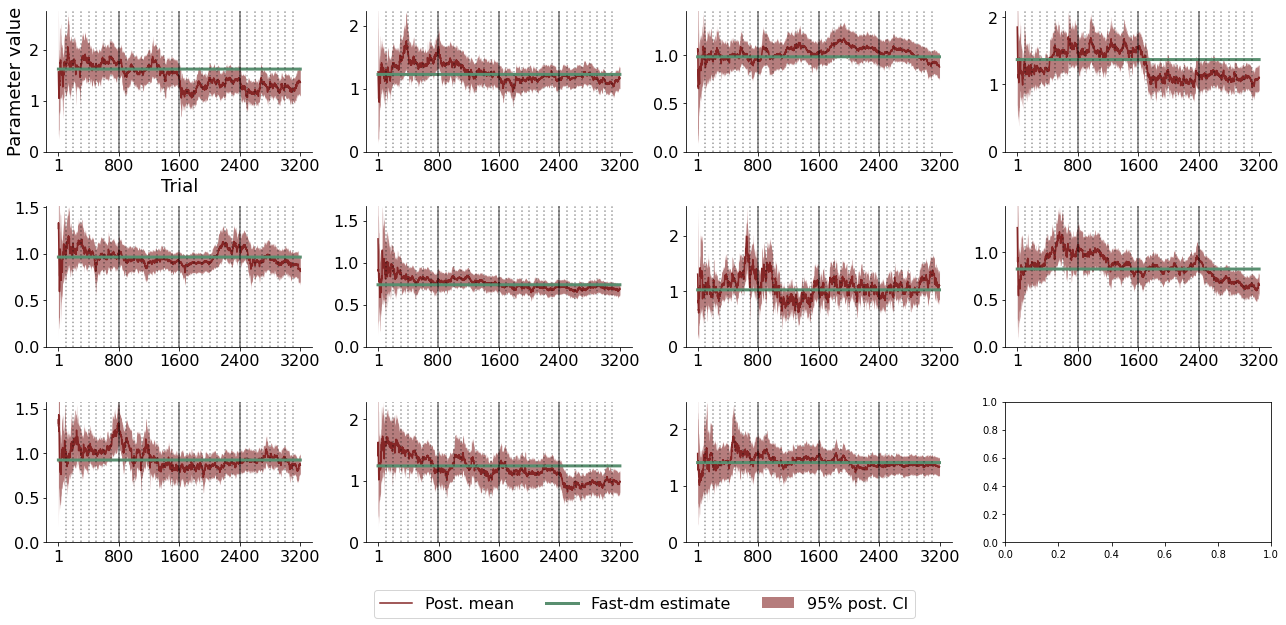

In [108]:
time = np.arange(x_nn.shape[1])
f, axarr = plt.subplots(3, 4, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    if i < 11:
        upper_y_ax = ci[:, i, 50:].flatten().max()

        ax.plot(time, means[i, :], color='#852626', label='Post. mean')
        ax.fill_between(time, ci[1, i, :], ci[0, i, :], color='#852626', alpha=0.6, linewidth=0, label='95% post. CI')

        # horizontal fast-dm params
        ax.plot(time, np.repeat(fast_dm_params[i, 4], x_nn.shape[1]), color='#598f70', alpha=1, lw=3, label='Fast-dm estimate')

        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)

        # ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_ylim(0, upper_y_ax)

        sns.despine(ax=ax)
        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                        bbox_to_anchor=(0.5, -0.05), ncol=4)

f.tight_layout()
f.savefig("../plots/threshold_param_all_sub.png", dpi=300, bbox_inches="tight")

## Evaluation: Simulated data & Parameter Recovery

In [ ]:
def pr_check_simulation(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data[:, 1:].argmax(axis=1)
    # get empirical response times
    emp_rt = np.abs(emp_data[:, 0], dtype=np.float64)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/n_sim, dtype=np.int32)
    theta = post_theta_t[idx]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta[sim, t, context[t]], theta[sim, t, 4], theta[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [ ]:
%%time
true_eta_z, true_theta_t_z, true_data = generator_fun(BATCH_SIZE, N_OBS)
true_theta_t_z.shape

In [ ]:
# amortized inference
post_eta_z = np.zeros((N_SAMPLES, BATCH_SIZE, N_OBS, N_PARAMS))
post_theta_t_z = np.zeros((N_SAMPLES, BATCH_SIZE, N_OBS, N_PARAMS))
for i in range(BATCH_SIZE):
    post_eta_z[:, i:i+1, :, :], post_theta_t_z[:, i:i+1, :, :] = network.sample_n(true_data[i:i+1], N_SAMPLES)
    print("Sim nr. {} is fitted".format(i+1))

In [ ]:
post_eta = unscale_z(post_eta_z, MACRO_MEAN, MACRO_STD)
post_theta_t = unscale_z(post_theta_t_z, MICRO_MEANS, MICRO_STDS)

true_eta = unscale_z(true_eta_z, MACRO_MEAN, MACRO_STD)
true_theta_t = unscale_z(true_theta_t_z, MICRO_MEANS, MICRO_STDS)

In [ ]:
np.save("../saved_arrays/post_eta_simulation.npy", post_eta)
np.save("../saved_arrays/post_theta_t_simulation.npy", post_theta_t)
np.save("../saved_arrays/true_eta_simulation.npy", true_eta)
np.save("../saved_arrays/true_theta_t_simulation.npy", true_theta_t)

In [ ]:
# predict data with neural for all subjects
pred_rt_neural = np.zeros((BATCH_SIZE, N_SIM, N_OBS))
sma_pred_rt_neural = np.zeros((BATCH_SIZE, N_SIM, N_OBS))

pred_rt_quantiles = np.zeros((BATCH_SIZE, 2, N_OBS))
pred_rt_medians = np.zeros((BATCH_SIZE, N_OBS))

true_rt =  np.zeros((BATCH_SIZE, N_OBS))
sma_true_rt =  np.zeros((BATCH_SIZE, N_OBS))

for sim in range(BATCH_SIZE):
    # predict RTs
    single_data = true_data[sim].numpy()
    pred_rt_neural[sim], sma_pred_rt_neural[sim], true_rt[sim], sma_true_rt[sim] = pr_check_simulation(single_data, post_theta_t[:, sim, :, :], N_SIM)
    # compute RT quantiles
    pred_rt_quantiles[sim] = np.quantile(sma_pred_rt_neural[sim], [0.05, 0.95], axis=0)
    pred_rt_medians[sim] = np.median(sma_pred_rt_neural[sim], axis=0)
    print("Sim nr. {} is predicted".format(sim+1))

In [ ]:
horizon=800
true_data_horizon = true_data[:, :N_OBS-horizon, :]

# inference on restircted data
post_eta_z_horizon = np.zeros((N_SAMPLES, BATCH_SIZE, N_OBS-horizon, N_PARAMS))
post_theta_t_z_horizon = np.zeros((N_SAMPLES, BATCH_SIZE, N_OBS-horizon, N_PARAMS))
for i in range(BATCH_SIZE):
    post_eta_z_horizon[:, i:i+1, :, :], post_theta_t_z_horizon[:, i:i+1, :, :] = network.sample_n(true_data_horizon[i:i+1], N_SAMPLES)
    print("Sim nr. {} is fitted".format(i+1))

In [ ]:
post_eta_last = unscale_z(post_eta_z_horizon[:, :, -1, :], MACRO_MEAN, MACRO_STD)
post_theta_last = unscale_z(post_theta_t_z_horizon[:, :, -1, :], MICRO_MEANS, MICRO_STDS)

In [ ]:
# calcualte mean posteriors
post_eta_last_means = post_eta_last.mean(axis=0)
post_theta_last_means = post_theta_last.mean(axis=0)

In [ ]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, BATCH_SIZE, horizon, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, BATCH_SIZE, horizon, 1))

context = true_data[:, :, 1:].numpy().argmax(axis=2)[:, T-horizon:]

for sim in range(BATCH_SIZE):
    for i in range(N_SIM):
        pred_theta_t = random_walk(post_theta_last_means[sim:sim+1], post_eta_last_means[sim:sim+1], horizon)
        pred_rt_horizon[i, sim:sim+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sim:sim+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sim, :, 0] = talib.SMA(pred_rt_horizon[i, sim, :, 0], timeperiod=5)

    print("Sim nr. {} is predicted".format(sim+1))

In [ ]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.05, 0.95], axis=0)

In [ ]:
np.save("../saved_arrays/pred_rt_neural_simulation.npy", pred_rt_neural)
np.save("../saved_arrays/sma_pred_rt_neural_simulation.npy", sma_pred_rt_neural)
np.save("../saved_arrays/pred_rt_quantiles_simulation.npy", pred_rt_quantiles)
np.save("../saved_arrays/pred_rt_medians_simulation.npy", pred_rt_medians)
np.save("../saved_arrays/true_rt_simulation.npy", true_rt)
np.save("../saved_arrays/sma_true_rt_simulation.npy", sma_true_rt)
np.save('../saved_arrays/pred_rt_horizon_medians_simulation.npy', pred_rt_horizon_medians)
np.save('../saved_arrays/pred_rt_horizon_quantiles_simulation.npy', pred_rt_horizon_quantiles)

In [ ]:
pred_rt_neural = np.load("../saved_arrays/pred_rt_neural_simulation.npy")
sma_pred_rt_neural = np.load("../saved_arrays/sma_pred_rt_neural_simulation.npy")
pred_rt_quantiles = np.load("../saved_arrays/pred_rt_quantiles_simulation.npy")
pred_rt_medians = np.load("../saved_arrays/pred_rt_medians_simulation.npy")
true_rt = np.load("../saved_arrays/true_rt_simulation.npy")
sma_true_rt = np.load("../saved_arrays/sma_true_rt_simulation.npy")
pred_rt_horizon_medians = np.load('../saved_arrays/pred_rt_horizon_medians_simulation.npy')
pred_rt_horizon_quantiles = np.load('../saved_arrays/pred_rt_horizon_quantiles_simulation.npy')

In [ ]:
# initialize figure
horizon = 800
for sub in range(BATCH_SIZE):
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})
    axrr = ax.flat
    # plot empiric and predicted response times series
    time = np.arange(N_OBS) 

    axrr[0].plot(time, sma_true_rt[sub], color="#062759", lw=1.4, alpha=0.7, label='SMA5: Simulated')
    axrr[0].plot(time[:N_OBS-horizon], pred_rt_medians[sub, :N_OBS-horizon], color='#852626', lw=1.4, label='SMA5: Retrodicted median', alpha=0.8)
    axrr[0].plot(time[N_OBS-horizon:], pred_rt_horizon_medians[sub], color="#b35032", lw=1.4, label='SMA5: Predicted multi-horizon median', alpha=0.6)
    axrr[0].fill_between(time[N_OBS-horizon:], pred_rt_horizon_quantiles[0, sub, :, 0], pred_rt_horizon_quantiles[1, sub, :, 0], color="#b35032", linewidth=0, alpha=0.4, label='Multi-horizon predictive uncertainty')
    axrr[0].fill_between(time[:N_OBS-horizon], pred_rt_quantiles[sub, 0, :N_OBS-horizon], pred_rt_quantiles[sub, 1, :N_OBS-horizon], color='#852626', linewidth=0, alpha=0.5, label='Retrodictive uncertainty')
    # for idx in np.argwhere(person_data.session.diff().values == 1):
    #     if idx == 800:
    #         axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    #     else:
    #         axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    # for idx in np.argwhere(person_data.block.diff().values == 1):
    #     if idx == 100:
    #         axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    #     else:
    #         axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    sns.despine(ax=axrr[0])
    axrr[0].grid(alpha=0.3)
    axrr[0].set_ylabel('RT(s)', fontsize=18, rotation=0, labelpad=40)
    axrr[0].set_xlabel('\nTrial', fontsize=18)
    axrr[0].tick_params(axis='both', which='major', labelsize=16)

    f.legend(fontsize=16, loc='center', 
            bbox_to_anchor=(0.5, -0.05), ncol=3)

    axrr[0].grid(b=None)
    axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

    # plot empiric and predicted response time dist
    plt.setp(ax, ylim=(0, np.nanmax(pred_rt_medians[sub])*1.2))
    sns.histplot(y=np.abs(true_rt[sub]), fill="#062759", color="#062759", alpha=0.7, label="Simulated", ax=axrr[1], stat="density", bins=250, linewidth=0)
    sns.kdeplot(y=pred_rt_neural[sub].flatten(), fill="#852626", color="#852626", alpha=0.3, label="Dynamic DDM", ax=axrr[1], linewidth=3.5)

    axrr[1].legend(fontsize=16)
    axrr[1].set_xlabel('', fontsize=18)
    axrr[1].tick_params(axis='both', which='major', labelsize=16)
    axrr[1].set_yticklabels('')
    axrr[1].set_xticklabels('')
    axrr[1].xaxis.set_ticks([])
    axrr[1].yaxis.set_ticks([])
    axrr[1].get_xaxis().set_visible(False)
    for line in axrr[1].get_lines():
        line.set_alpha(1)
    sns.despine(ax=axrr[1], bottom=True)

    axrr[0].annotate('Retrodiction',
                xy=(0.38, 1), xytext=(0, -15),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].annotate('Prediction',
                xy=(0.84, 1), xytext=(0, -15),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].tick_params(length=8)

    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    # f.savefig("../plots/rt_time_series_simulation_{}.png".format(sub+1), dpi=300, bbox_inches='tight')

In [ ]:
def plot_dynamic_posteriors_simulation(dynamic_posterior, ground_truths, par_labels, par_names, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    std = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0).max()
    upper_y_ax = post_max + 1

    sigma_factors = [1]
    alphas = [0.5]

    time = np.arange(dynamic_posterior.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Post. mean', lw=1.5, alpha=0.8)
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Post. std. deviation')
            ax.plot(time, ground_truths[:, i], color="#062759", label='True Dynamic', lw=2, alpha=0.8)

        sns.despine(ax=ax)
        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)


        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)
        if i < 4:
            ax.set_ylim(0, upper_y_ax)
        else:
            ax.set_ylim(0)
        ax.grid(False)


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()
    # f.savefig("../plots/param_dynamic_sub_{}.png".format(sub+1), dpi=300, bbox_inches="tight")

In [ ]:
for sim in range(BATCH_SIZE):
    plot_dynamic_posteriors_simulation(post_theta_t[:, sim, :, :], true_theta_t[sim], PARAM_LABELS, PARAM_NAMES)

In [ ]:
PARAM_NAMES  = [r'$\eta_{v_1}$', r'$\eta_{v_2}$', r'$\eta_{v_3}$', r'$\eta_{v_4}$', r'$\eta_{a}$', r'$\eta_{\tau}$']

for sim in range(BATCH_SIZE):
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        sns.kdeplot(post_eta[:, sim, 2999, i], ax=ax, color='#852626', fill='#852626', alpha=0.5, label="Post.", lw=2)
        ax.axvline(true_eta[sim, i], label='True', color="#062759", lw=2)


        if i == 0:
            ax.set_xlabel('Parameter value', fontsize=18)
            ax.set_ylabel("Density", fontsize=18)
        else:
            ax.set_ylabel("", fontsize=18)


        ax.set_title('Eta ' + PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
        # ax.set_xticks([1, 800, 1600, 2400, 3200])

        ax.tick_params(axis='both', which='major', labelsize=16)
        # if i < 4:
        #     ax.set_ylim(0, upper_y_ax)
        # else:
        #     ax.set_ylim(0)

        sns.despine(ax=ax)
        ax.grid(False)


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()